<a href="https://colab.research.google.com/github/palver7/deeplearning/blob/master/FashionMNIST_with_VGG16_no_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from torchvision.datasets import FashionMNIST
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import random_split,DataLoader
import os
import copy

plt.ion()

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
samples = 64 #num of sample per batch
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(224),
        transforms.Grayscale(3),
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

trainset = FashionMNIST(root='./data', train=True, 
                        download=True, transform=data_transforms['train'])

trainset, valset = random_split(trainset, (50000,10000))

trainloader = DataLoader(trainset, batch_size=samples, shuffle=True, 
                                          num_workers=4)

testset = FashionMNIST(root='./data', train=False, 
                       download=True,transform=data_transforms['test'])

testloader = DataLoader(testset, batch_size=samples, shuffle=False, 
                                         num_workers=4)

valloader = DataLoader(valset, batch_size=samples, shuffle=False, 
                                         num_workers=4)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {'train': trainloader, 'val': valloader, 'test': testloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dress Ankle Boot T-shirt/top Trouser Shirt Trouser Dress Sandal


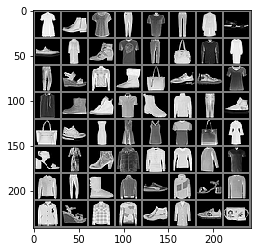

In [4]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [0]:
def train_model(model, criterion, optimizer, scheduler, val_acc, 
                val_loss, train_acc, train_loss, epoch,
                num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    list = {'train': {'acc': train_acc, 'loss': train_loss}, 
        'val':{'acc': val_acc, 'loss': val_loss}}
    next = epoch
    for epoch in range(next, next + num_epochs):
        print('Epoch {}/{}'.format(epoch, next + num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        
            running_loss = 0.0
            running_corrects = 0
        
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()
        
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            list[phase]['loss'].append(epoch_loss)
            list[phase]['acc'].append(epoch_acc.item())
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
        
    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, epoch + 1

In [7]:
model = torchvision.models.vgg16(pretrained=True)
#for param in model.parameters():
#    param.requires_grad = False


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 105889670.45it/s]


In [0]:
# Lists for plotting loss and accuracy.
# Rerun this cell if you want to restart training to empty the lists.
epoch = 0
val_acc = []
val_loss = []
train_acc = []
train_loss = []

In [9]:
model, epoch = train_model(model, criterion, optimizer, scheduler, val_acc, val_loss, 
                    train_acc, train_loss, epoch, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.4494 Acc: 0.8397
val Loss: 0.2846 Acc: 0.8993

Epoch 1/19
----------
train Loss: 0.2631 Acc: 0.9069
val Loss: 0.2537 Acc: 0.9092

Epoch 2/19
----------
train Loss: 0.2210 Acc: 0.9212
val Loss: 0.2681 Acc: 0.9036

Epoch 3/19
----------
train Loss: 0.1949 Acc: 0.9319
val Loss: 0.2249 Acc: 0.9218

Epoch 4/19
----------
train Loss: 0.1741 Acc: 0.9380
val Loss: 0.2169 Acc: 0.9260

Epoch 5/19
----------
train Loss: 0.1570 Acc: 0.9442
val Loss: 0.2352 Acc: 0.9203

Epoch 6/19
----------
train Loss: 0.1189 Acc: 0.9587
val Loss: 0.1997 Acc: 0.9313

Epoch 7/19
----------
train Loss: 0.1114 Acc: 0.9613
val Loss: 0.2016 Acc: 0.9336

Epoch 8/19
----------
train Loss: 0.1074 Acc: 0.9628
val Loss: 0.2026 Acc: 0.9326

Epoch 9/19
----------
train Loss: 0.1033 Acc: 0.9645
val Loss: 0.1998 Acc: 0.9357

Epoch 10/19
----------
train Loss: 0.1014 Acc: 0.9648
val Loss: 0.2024 Acc: 0.9342

Epoch 11/19
----------
train Loss: 0.0985 Acc: 0.9659
val Loss: 0.2011 Acc: 0.9339

Ep

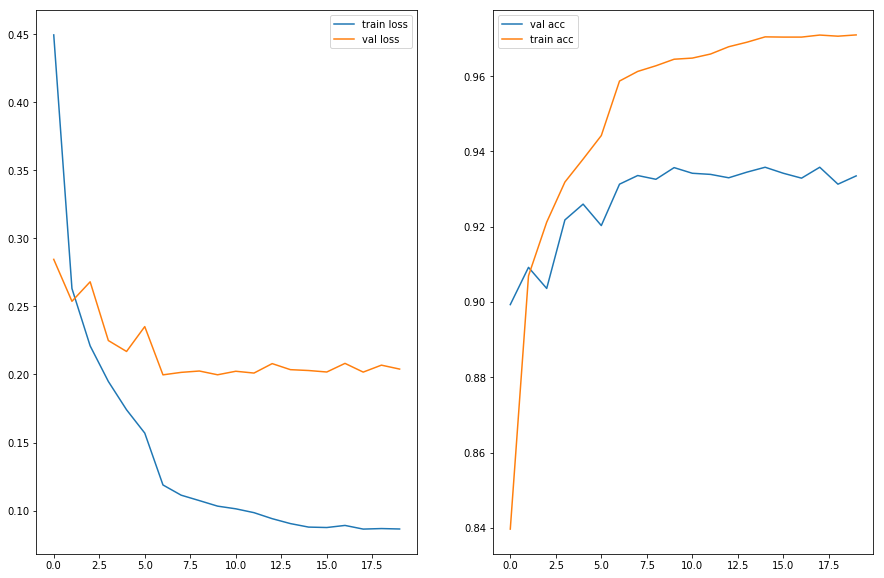

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(train_loss, label='train loss')
ax1.plot(val_loss, label='val loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(val_acc, label='val acc')
ax2.plot(train_acc, label='train acc')
ax2.legend()

GroundTruth:  Ankle Boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt


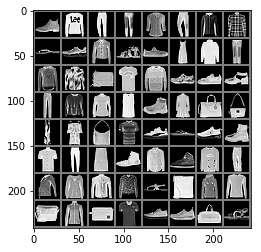

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] \
                                for j in range(8)))

Predicted:  Ankle Boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt


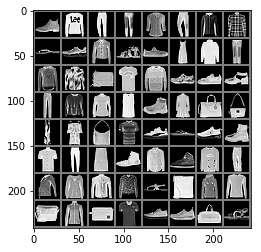

In [13]:
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
imshow(torchvision.utils.make_grid(images.cpu()))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] \
                              for j in range(8)))

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on the test images : %.4f' %
     (correct/total))

Accuracy of the network on the test images : 0.9304


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
      
for i in range(10):
    print('Accuracy of %5s : %.4f' % 
         (classes[i], class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 0.8811
Accuracy of Trouser : 0.9821
Accuracy of Pullover : 0.9102
Accuracy of Dress : 0.9515
Accuracy of  Coat : 0.9145
Accuracy of Sandal : 0.9800
Accuracy of Shirt : 0.7952
Accuracy of Sneaker : 0.9873
Accuracy of   Bag : 0.9801
Accuracy of Ankle Boot : 0.9733


Comparing training and validation accuracy and the training time of feature extraction (freezing the backpropagation), finetuning the model (use pretrained model, not freezing the backpropagation), and training the model from scratch ( no pretrained model).

###the feature extraction results are:
5 epochs 224 x 224 pixels
Training complete in 26m 45s
Best val Acc: 0.851700

###the finetuning results are: (warning: although backpropagation was enabled, only the last layer is optimized. The real finetuning result is at the bottom.) 
5 epochs 224 x 224 pixels
Training complete in 67m 30s
Best val Acc: 0.850600

comparison between freezing the gradients and not is clear on the running time; the former is faster than the latter by 40 mins. The best val_acc does not change much. The finetuned model's val_acc in the final epoch decreased compared to the previous epoch.

### the result of training with 1 channel and not using pretrained parameters:

Training complete in 66m 0s
Best val Acc: 0.630300

the accuracy drops from ~ 80% to ~60% for validation, but the training time is only faster by 1.5 minutes compared to initialization with pretrained parameters. 

### the result of training with 3 channels without pretrained parameters:

Training complete in 67m 34s
Best val Acc: 0.663300

training is 1.5 mins slower than 1 channel, the increase in best val accuracy is 0.03 or 3% .

### result of finetuning with pretrained parameters 
20 epochs 28 x 28 pixels.

Training complete in 19m 54s
Best val Acc: 0.935800

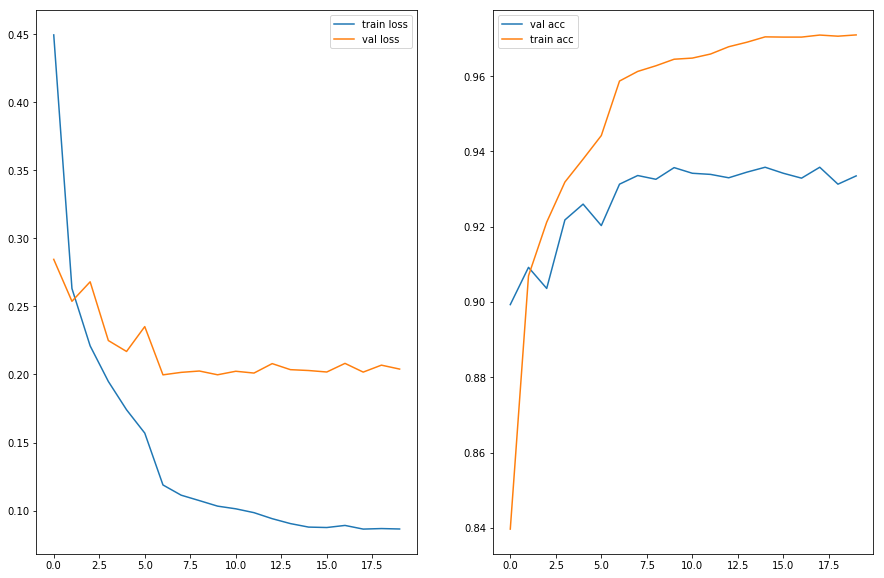

True result of finetuning the pretrained model after 20 epochs and 28 x 28 pixels.

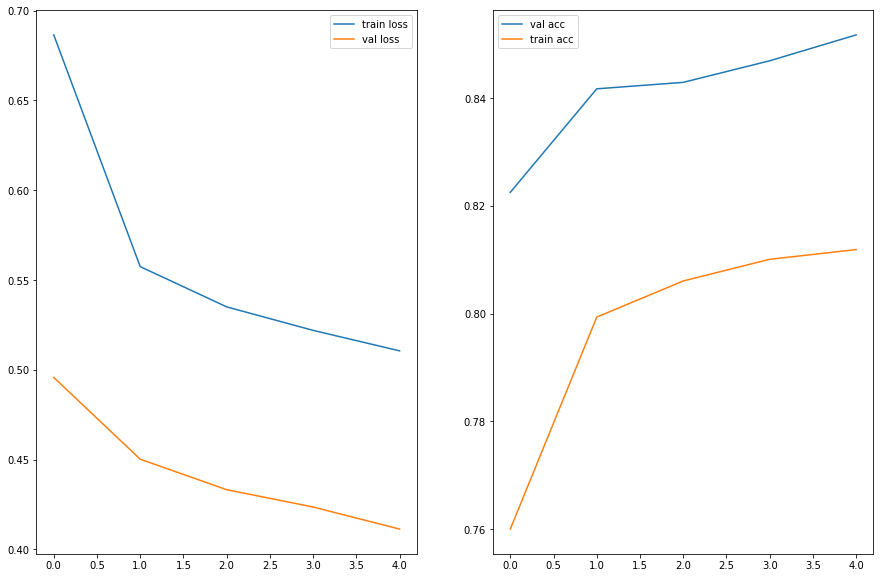

Result of feature extraction / freezing the backpropagation

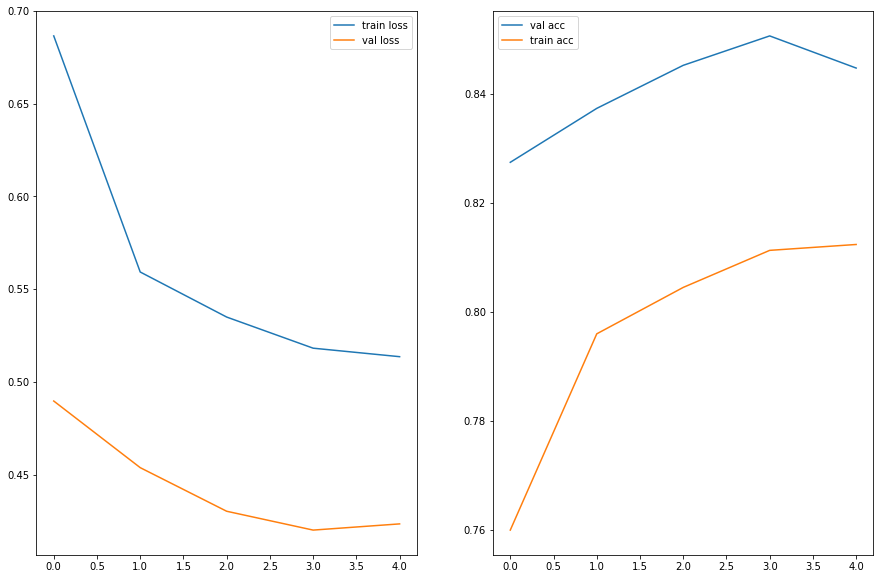

finetuning result initialized with pretrained model but  changing the neural network's parameters.

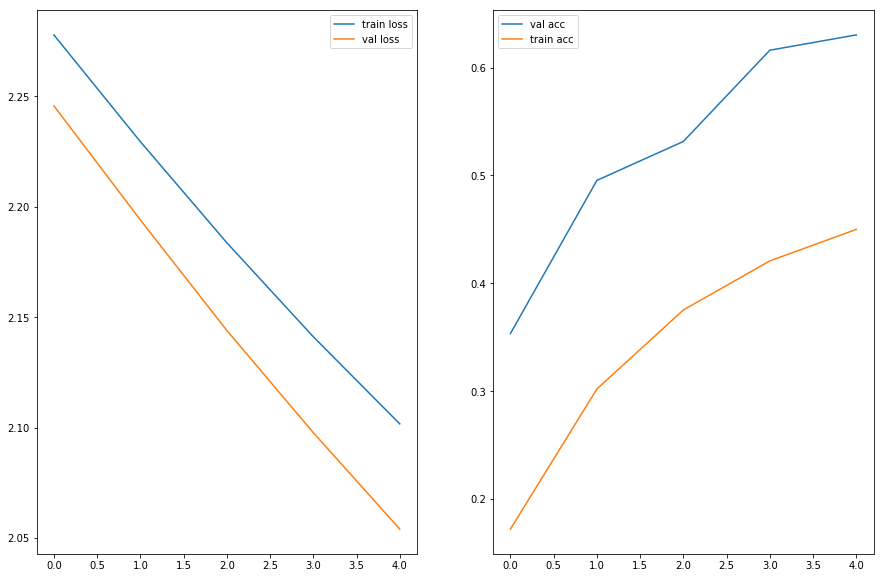

results of training the model with 1 channel and no pretrained parameters.

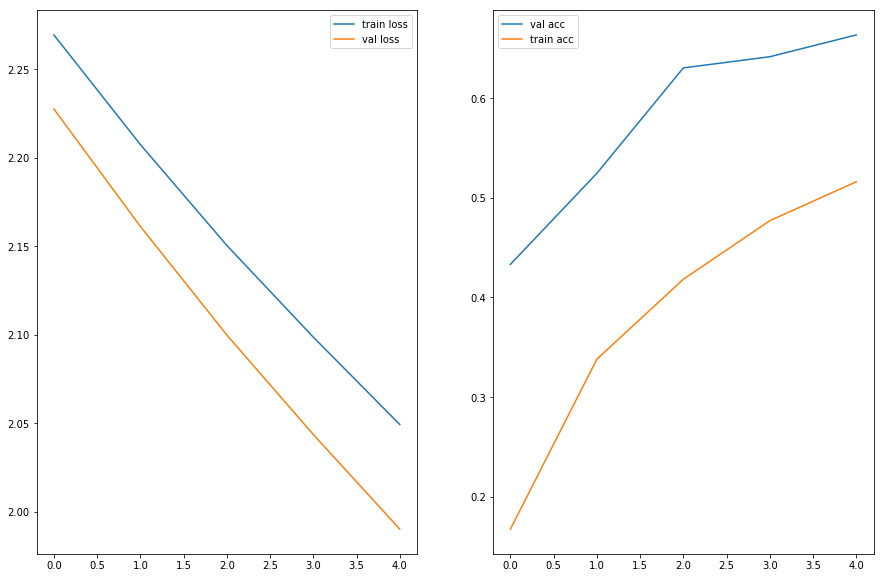

result of training with no pretrained parameters and using 3 channels.

In [0]:
torch.save({'epoch' : epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss, 'val_loss': val_loss, 
            'train_acc': train_acc, 'val_acc': val_acc}, 
           './FMNIST_VGG16_noresize.tar')

In [0]:
checkpoint = torch.load('./FMNIST_VGG16_noresize.tar')
model.load_state_dict(checkpoint['model_state_dict'])  
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']
val_loss = checkpoint['val_loss']
val_acc = checkpoint['val_acc']
epoch = checkpoint['epoch']
